In [1]:
#My local copy.
import h5py 
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
import os
import tqdm
import math
from scipy.interpolate import RectBivariateSpline
import copy
import shutil
from scipy.optimize import curve_fit

In [2]:
param = {'font.size'          : 35.0 ,
         'figure.figsize'     : [16,9],
        'xtick.labelsize'     : 20.0 ,
        'ytick.labelsize'     : 20.0 ,
        'lines.linewidth'      : 3,
        'figure.autolayout'    : True,
        'savefig.dpi'         : 201   }
plt.rcParams.update(param)

In [3]:
f2r="many_spikes.out.h5"

In [4]:
with h5py.File(f2r,'r') as out:
    for key in out.keys():
        print("========================================================================================================================")
        print(key)
        print('*********')
        print(out[key].keys())

Beam
*********
<KeysViewHDF5 ['alphax', 'alphay', 'betax', 'betay', 'bunching', 'bunchingphase', 'current', 'efield', 'emitx', 'emity', 'energy', 'energyspread', 'pxposition', 'pyposition', 'xposition', 'xsize', 'yposition', 'ysize']>
Field
*********
<KeysViewHDF5 ['dgrid', 'intensity-farfield', 'intensity-nearfield', 'ngrid', 'phase-farfield', 'phase-nearfield', 'power', 'xposition', 'xsize', 'yposition', 'ysize']>
Global
*********
<KeysViewHDF5 ['gamma0', 'lambdaref', 'one4one', 'sample', 'scan', 'slen', 'time']>
Lattice
*********
<KeysViewHDF5 ['aw', 'ax', 'ay', 'chic_angle', 'chic_lb', 'chic_ld', 'chic_lt', 'cx', 'cy', 'dz', 'gradx', 'grady', 'ku', 'kx', 'ky', 'phaseshift', 'qf', 'qx', 'qy', 'slippage', 'z', 'zplot']>
Meta
*********
<KeysViewHDF5 ['InputFile', 'LatticeFile', 'TimeStamp', 'User', 'Version']>


In [5]:
with h5py.File(f2r,'r') as out:
    power = out['Field/power'][()]
    undZ = out['Lattice/z'][()]
    n = np.argmin(np.abs(25-undZ))    #Find the index n corresponding to z, n=534 here.
    #print(n)
    print(len(power[n,:]))
    #print(power[2, -1])

4860


In [6]:
def showpower(fname,z=0,ave=False):
    with h5py.File(fname,'r') as out:
        power = out['Field/power'][()]
        undZ = out['Lattice/z'][()]
        t = np.linspace(0,out['Global/slen'][()]/constants.c,len(power[-1,:])) #Number of points is 4860
        if ave==True:
            avep = np.mean(power, axis=1)
            return undZ,avep
        else:
            phase = out['Field/phase-nearfield'][()]
            n = np.argmin(np.abs(z-undZ))   #Find the index n corresponding to z
            localp = power[n,:]             #length of power is 4860.
            localphi= phase[n,:]
            return t, localp,localphi, z


In [7]:
def emit(fname):
    with h5py.File(fname,'r') as out:
        emit_x=out['Beam/emitx'][()]
        emit_y=out['Beam/emity'][()]
        #emitx,emity=np.mean(emit_x, axis=1),np.mean(emit_y, axis=1)
        return emit_x, emit_y
        

In [8]:
def showorbit(fname):
    with h5py.File(fname,'r') as out:
        xsize=out['Beam/xsize'][()]
        ysize=out['Beam/ysize'][()]
        xpos=out['Beam/xposition'][()]
        ypos=out['Beam/yposition'][()]
        undZ=out['Lattice/z'][()]
        t=np.linspace(0,out['Global/slen'][()]/constants.c,len(xsize[-1,:]))
        return xsize,ysize,xpos,ypos,undZ,t

In [9]:
def showbunching(fname):
    with h5py.File(fname,'r') as out:
        bunching=out['Beam/bunching'][()]
        undZ=out['Lattice/z'][()]
        t=np.linspace(0,out['Global/slen'][()]/constants.c,len(bunching[-1,:]))
        return bunching, undZ, t

In [10]:
def showcurrent(fname):
    with h5py.File(fname,'r') as out:
        cur = out['Beam/current'][()]
        xsize=out['Beam/xsize'][()]
        t=np.linspace(0,out['Global/slen'][()]/constants.c,len(xsize[-1,:]))
        return t, cur.transpose()

In [11]:
def showespread(fname):
    with h5py.File(fname,'r') as out:
        espread = out['Beam/energyspread'][()]
        undZ=out['Lattice/z'][()]
        return undZ,espread

In [12]:
def Spectrumf(fname,z0):
    t, localp,localphi, zpos=showpower(fname,z0,False)
    with h5py.File(fname,'r') as out:
        xlamds = out['Global/lambdaref'][()]
        zsep= out['Global/sample'][()]
        ps=localp
        phis=localphi
        e_charge = constants.e
        h_plank = constants.h
        c_speed = constants.c
        nslice = len(t)
        f0 = c_speed/xlamds
        deltaT = xlamds*zsep/c_speed
        Fs = 1/deltaT                              # Sampling frequency
        Er = 0.01                                  # Energy resolution(ev)
        Fr = e_charge*Er/h_plank                                # Er = h*Fr/e
        Sp = np.round(Fs/Fr)                       # The estimation of sampling point
        P = np.zeros(int(np.round((Sp-nslice)/2)))
        power = np.concatenate((P,ps,P))
        phase = np.concatenate((P,phis,P))
        N = len(power)
        Nfft = np.int64(2**np.ceil(np.log2(N)))    #Change to np.int64 on 12/27 to avoid warning.
        Esase = np.sqrt(power)*np.exp(-1j*phase)   #Form the complex data.
        t = np.array(range(len(Esase)))*deltaT
        energy0 = np.trapz(t,abs(Esase)**2)
        Ef = np.fft.fftshift(np.fft.fft(Esase,Nfft))
        f = Fs*(np.array(range(1,Nfft+1))*1.0-(Nfft+1)/2.0)/Nfft+f0
        lamda = c_speed/f
        energy1 = np.trapz(lamda,abs(Ef)**2)
        Nor = abs(energy0/energy1)
        Ef = np.sqrt(Nor)*Ef
        return Ef, f, lamda, 12.39*1000/(lamda*1e10)

In [13]:
def GS_alg(input_power, input_phase, Maxiter):   #input_power: time domain power, input_phase: time domain phase
    N = len(input_power)
    signal = np.sqrt(input_power)*np.exp(1j*input_phase)
    
    #Maxiter = 10000;                                 #Max number of iterations
    error_tol = 1                                #Error tolerance


    f = np.absolute(signal)                                #Magnitude of sampled points, known priori
    F = np.absolute(np.fft.fft(signal)/1)
    

    phi = -1.31*np.ones(N)  #Constant initial phase         #Constant initial phase, debug only, 0.33 seems to be ok.
    #phi = np.random.uniform(-math.pi, math.pi, N)
    x = f*np.exp(1j*phi)

    k = 0;

    
    error_test = np.zeros((2, Maxiter))
    error_test[0,0] = 3          #FFT domain magnitude error
    error_test[1,0] = 3          #Time domain magnitude error
    
    while ((error_test[1, k] > error_tol) and (k < Maxiter-1)):  
        k = k + 1
        X = np.fft.fft(x)/1                                                 #DFT of estimate
        error_test[0, k] = math.sqrt(1)*np.linalg.norm(abs(X) - F)          #diffraction magnitude error, from original object plane.  
        ############################################
        Y = F*np.exp(1j*np.angle(X))
        ############################################
        y = 1*np.fft.ifft(Y);                                      #IDFT of estimate
        error_test[1, k] = np.linalg.norm(abs(y)-f);                #Object plane magnitude error
        ############################################
        x = f*np.exp(1j*np.angle(y))
    
    error = error_test[1, :]
    
    return(k, y, signal, error)

## gain curve

Text(0, 0.5, 'Power (W)')

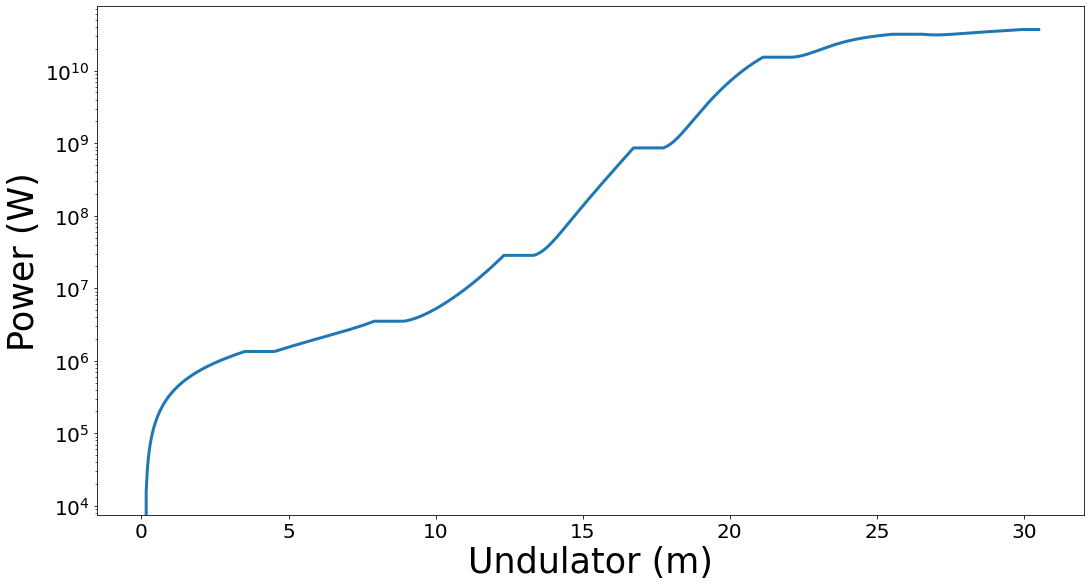

In [14]:
undZ, avep= showpower(f2r,0,True)
#plt.subplot(1,2,1)
#plt.plot(undZ,avep[0:-1])
#plt.xlabel('Undulator (m)')
#plt.ylabel('Power (W)')
#plt.subplot(1,2,2)
plt.semilogy(undZ,avep[0:-1])
plt.xlabel('Undulator (m)')
plt.ylabel('Power (W)')

## Power profile 
at Z<sub>0</sub>

4860


numpy.ndarray

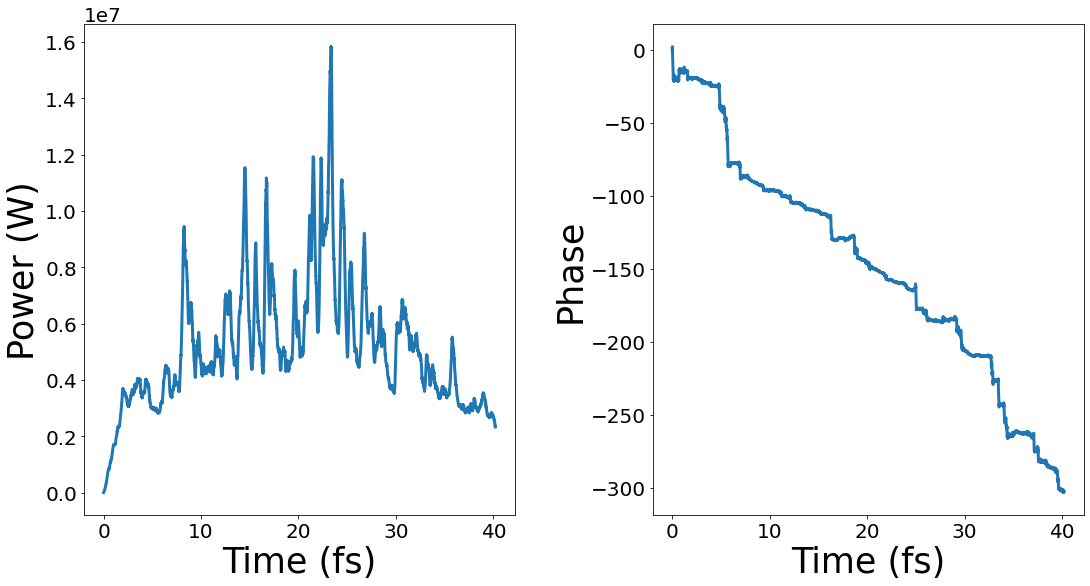

In [15]:
t, localp,locaphi ,zpos = showpower(f2r,10)
plt.subplot(1,2,1)
plt.plot(t*1e15,localp)
plt.xlabel('Time (fs)')
plt.ylabel('Power (W)')
plt.subplot(1,2,2)
plt.plot(t*1e15,np.unwrap(locaphi))
#plt.plot(t*1e15,locaphi)
plt.xlabel('Time (fs)')
plt.ylabel('Phase')
print(len(localp))   #power is 2 dimension, 645 x 4860
type(localp)
type(locaphi)

9999


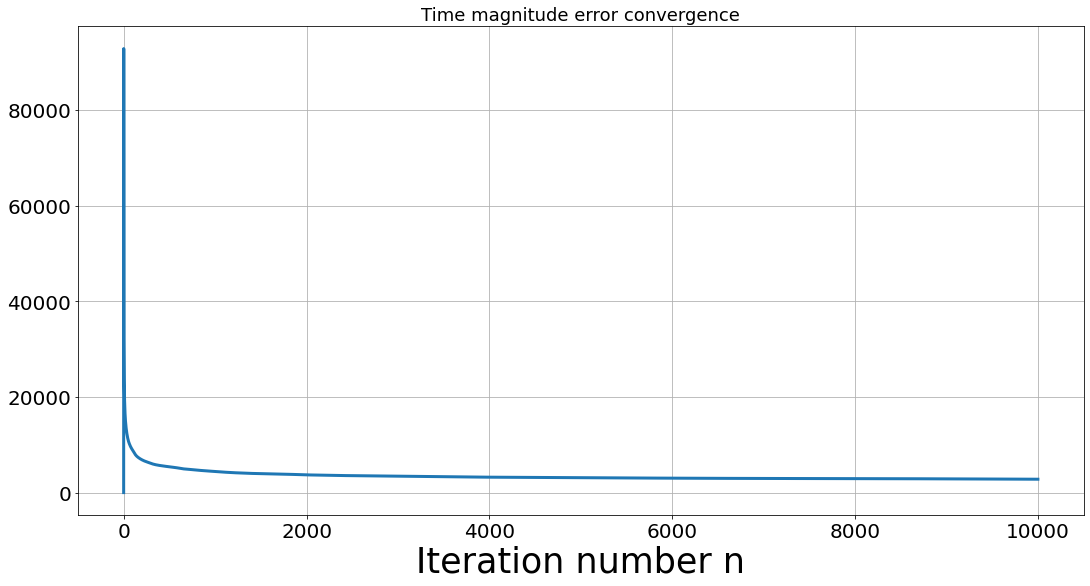

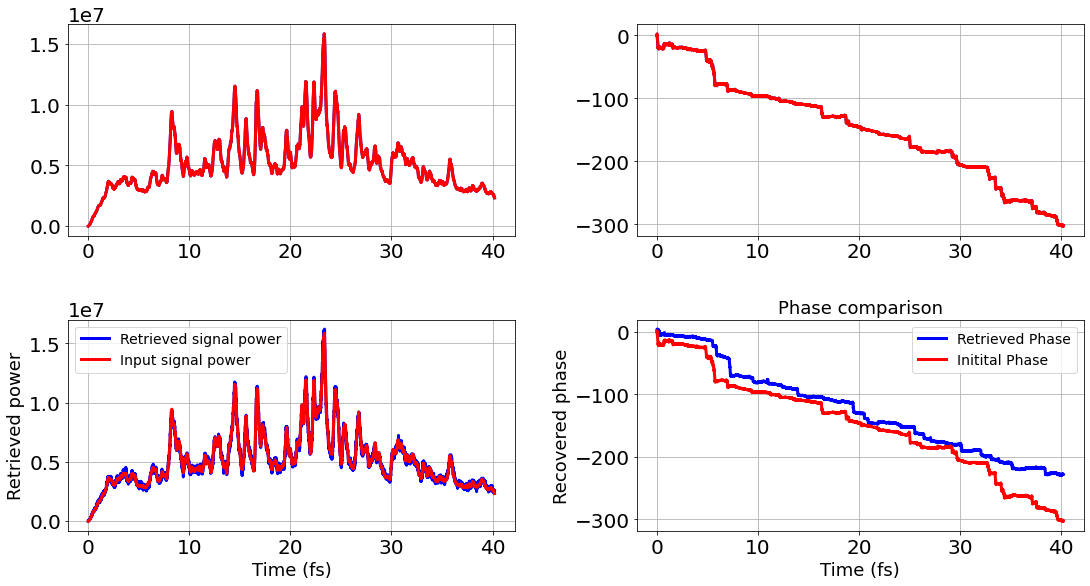

In [16]:
#Insert phase retrieval algorithm here
#print(type(localp))
k, ret_out, input, error = GS_alg(localp, locaphi, 10000)
print(k)
#print(error[-10:])

#Generate csv file to check in matlab.
#np.savetxt('test_p.out', localp)
#np.savetxt('test_phi.out', locaphi)

plot1 = plt.figure(1)
plt.plot(error)
plt.title("Time magnitude error convergence", fontsize=18)
plt.xlabel('Iteration number n')
plt.grid()

plot2 = plt.figure(2)
plt.subplot(2,2,1)
plt.plot(t*1e15,np.absolute(input)**2,'b-', label="Retruned signal power")
plt.plot(t*1e15,localp,'r-', label="Input signal power")
plt.grid()


plt.subplot(2,2,2)
plt.plot(t*1e15, np.unwrap(np.angle(input)),'b-', label="Returned signal phase")
plt.plot(t*1e15, np.unwrap(locaphi),'r-', label="Input signal phase")
plt.grid()

plt.subplot(2,2,3)
plt.plot(t*1e15,np.absolute(ret_out)**2, 'b-', label="Retrieved signal power")
plt.plot(t*1e15,localp,'r-', label="Input signal power")
plt.xlabel('Time (fs)', fontsize=18)
plt.ylabel('Retrieved power', fontsize=18)
plt.legend(loc="upper left", prop={"size":14})
plt.grid()

plt.subplot(2,2,4)
plt.plot(t*1e15, np.unwrap(np.angle(ret_out)), 'b-', label="Retrieved Phase")
plt.plot(t*1e15,np.unwrap(locaphi), 'r-', label="Initital Phase")
plt.legend(loc="upper right", prop={"size":14})
plt.xlabel('Time (fs)', fontsize=18)
plt.ylabel('Recovered phase', fontsize=18)
plt.title("Phase comparison", fontsize=18)
plt.grid()

38
[ 0.16352725-1.29938579j -0.03815816-1.73589262j  0.37988738-1.47539191j
  0.5060829 -1.68516402j -0.49583952-1.77047511j  0.99304144-1.55211513j
  0.81211223-1.3814011j   0.70907698-1.56058439j  0.68226973-1.10157897j
 -0.50650839+1.01780307j]


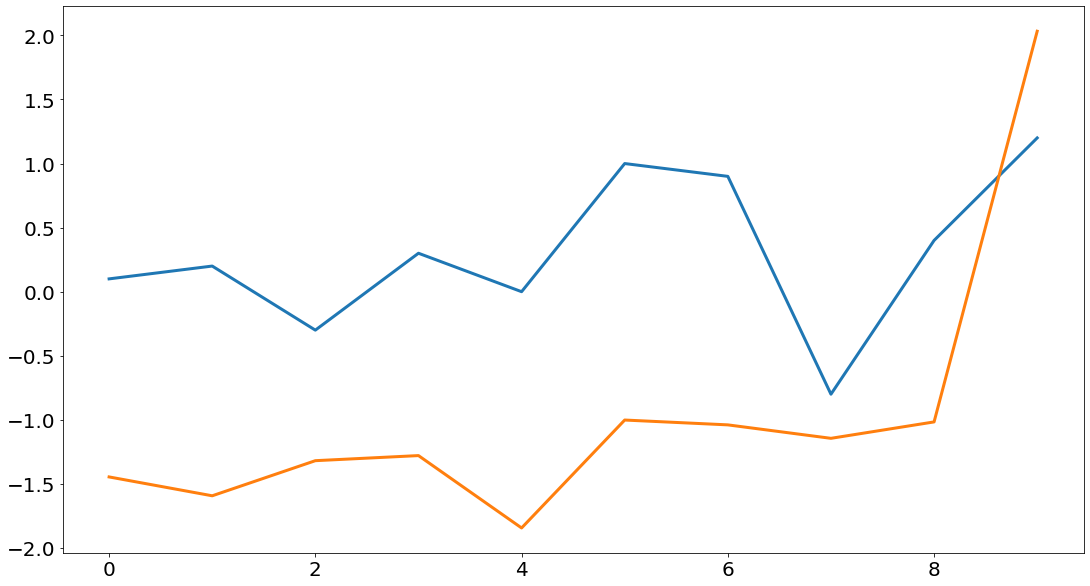

In [17]:
#This section is to ensure 1 to 1 match with matlab code 'GS_Phase_Retrieval_Function.m' on 12/30/2021
simple_p = [1,2,3,4,5,4,3,2,1,0.4]
simple_phi = [0.1, 0.2, -0.3, 0.3, 0, 1.0, 0.9, -0.8, 0.4, 1.2]
#ss = np.sqrt(np.asarray(simple_p))*np.exp(1j*np.asarray(simple_phi))
#type(ss)
k1, ret_out1, input1, error1 = GS_alg(np.asarray(simple_p), np.asarray(simple_phi), 10000)
print(k1)
print(ret_out1)
plt.plot(np.unwrap(simple_phi))
plt.plot(np.unwrap(np.angle(ret_out1)))

In [18]:
t,cur=showcurrent(f2r)

Text(0, 0.5, 'Current (A)')

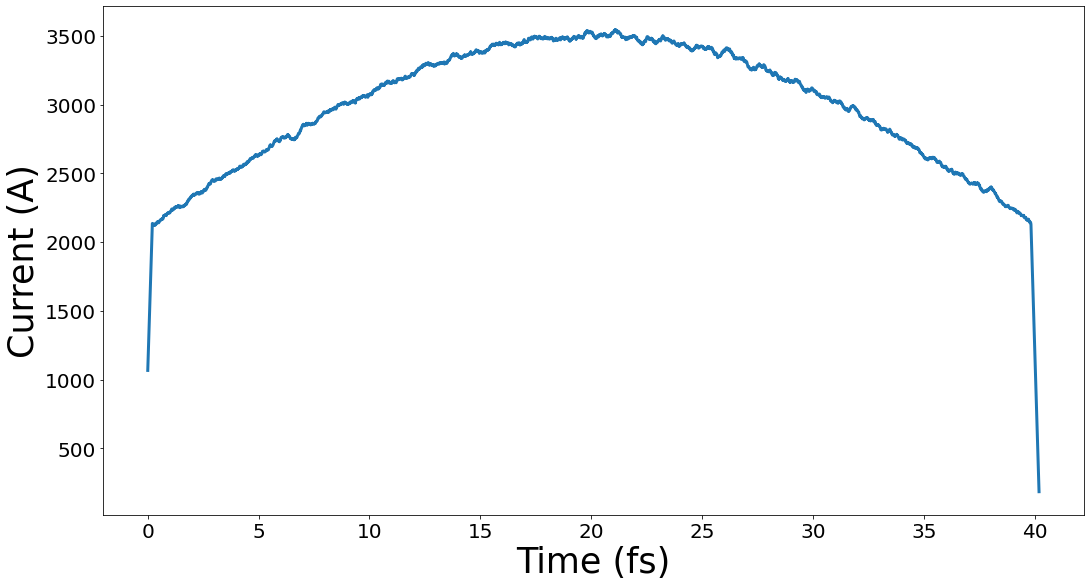

In [19]:
plt.plot(t*1e15,cur)
plt.xlabel('Time (fs)')
plt.ylabel('Current (A)')

In [20]:
xsize,ysize,xpos,ypos,undZ,t = showorbit(f2r)

Text(0, 0.5, 'Time (fs)')

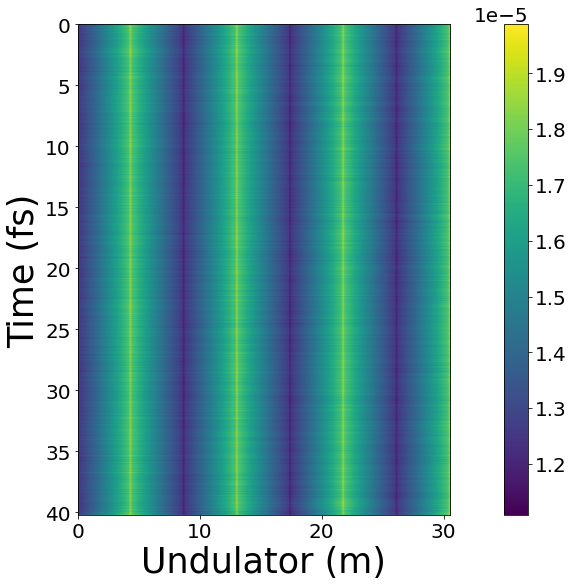

In [21]:
plt.imshow(xsize.transpose(),extent=[np.min(undZ),np.max(undZ),np.max(t)*1e15,np.min(t)*1e15])
plt.colorbar()
plt.xlabel('Undulator (m)')
plt.ylabel('Time (fs)')

In [22]:
bunching,undZ,t = showbunching(f2r)

Text(0, 0.5, 'Time (fs)')

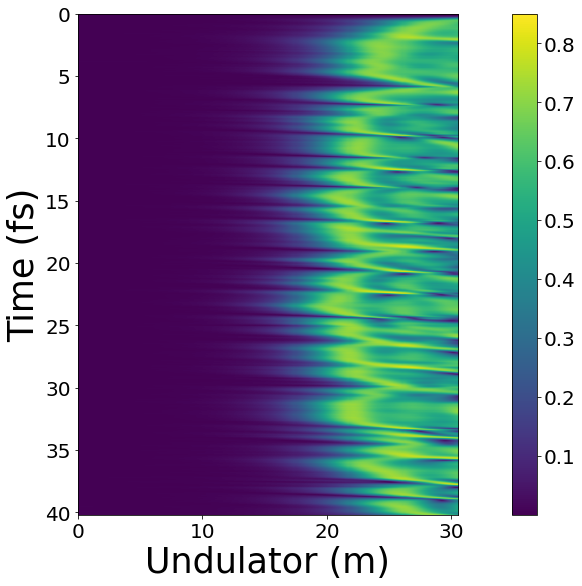

In [23]:
plt.imshow(bunching.transpose(),extent=[np.min(undZ),np.max(undZ),np.max(t)*1e15,np.min(t)*1e15])
plt.colorbar()
plt.xlabel('Undulator (m)')
plt.ylabel('Time (fs)')

In [24]:
Ef, f, lamda, phE=Spectrumf(f2r,100)
pf = np.abs(Ef)**2

(495.0, 510.0)

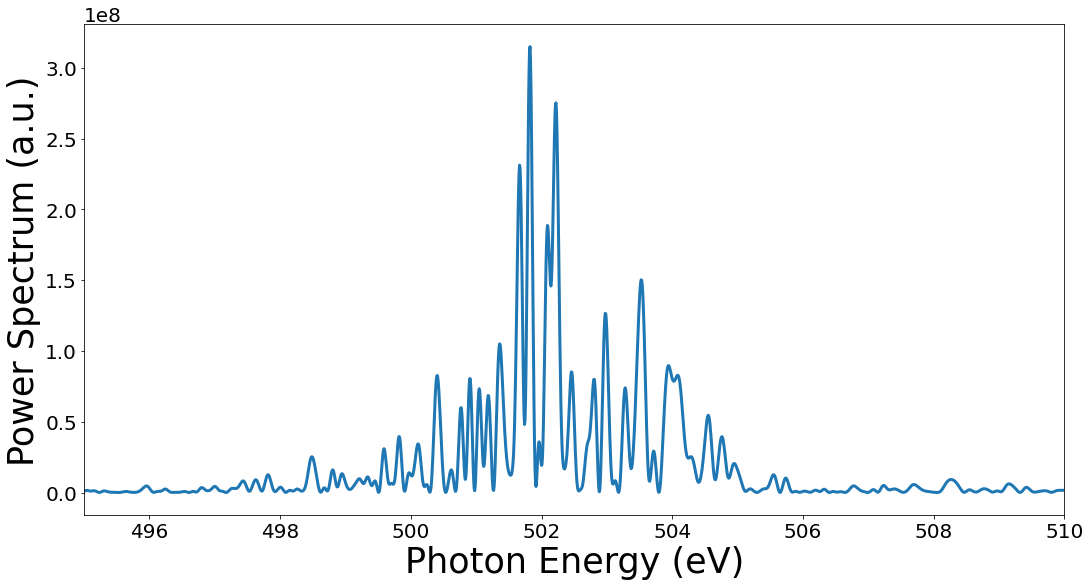

In [25]:
plt.plot(phE,pf)
plt.ylabel("Power Spectrum (a.u.)")
plt.xlabel("Photon Energy (eV)")
plt.xlim([495,510])

In [26]:
fname="many_spikes.643.fld.h5"

In [27]:
fld=h5py.File(fname,'r')

In [28]:
nslice=fld['slicecount'][()][0]
ngrid=fld['gridpoints'][()][0]
print(nslice)
print(ngrid)

4860
301


In [29]:
Efield=np.zeros((nslice,ngrid,ngrid))+np.zeros((nslice,ngrid,ngrid))*1j

In [30]:
rfd = fld['slice000500'+'/field-real'][()]  #This section is purely a test to understand the data type and reshpae 
type(rfd)
rfd2 = rfd.reshape([ngrid, ngrid])
type(rfd2)
len(rfd2)
rfd2

array([[ 0.10247357,  3.42430222, 12.8481198 , ..., 37.61721149,
        28.72657024, 14.55195714],
       [-4.50213009,  1.33522978, 20.3729558 , ..., 69.36524544,
        49.40990801, 24.06967176],
       [-9.81937925, -3.27830515, 21.76505009, ..., 84.06033893,
        51.70948109, 21.9035899 ],
       ...,
       [-6.7294715 , -7.23423582,  3.73922994, ..., 33.49213706,
        22.14674927, 11.06763153],
       [-1.98036528, -1.65697064,  5.1209137 , ..., 11.48995135,
         8.87774499,  5.57184132],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [31]:
rfd.shape

(90601,)

In [32]:
rfd2.shape

(301, 301)

In [33]:
for i in tqdm.trange(1,nslice+1):
    islice='slice'+str(i).zfill(6)
    rfield = fld[islice+'/field-real'][()]
    ifield = fld[islice+'/field-imag'][()]
    rfield = rfield.reshape([ngrid,ngrid])
    ifield = ifield.reshape([ngrid,ngrid])
    field = rfield+1j*ifield
    Efield[i-1,:,:]=field

100%|██████████| 4860/4860 [00:10<00:00, 479.73it/s]


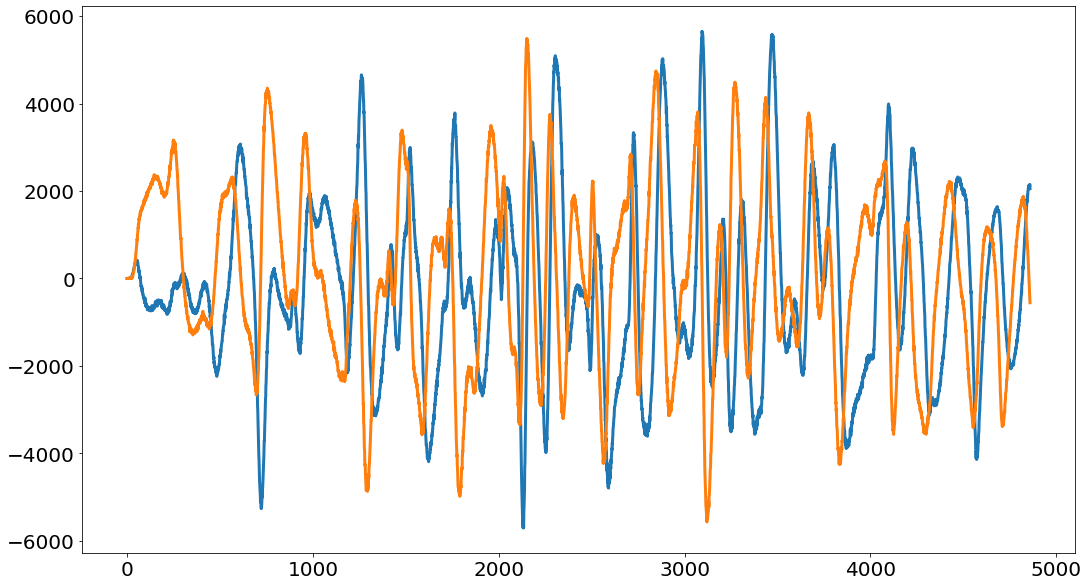

In [34]:
plt.plot(np.arange(nslice),Efield[:,150,150].real)
plt.plot(np.arange(nslice),Efield[:,150,150].imag)

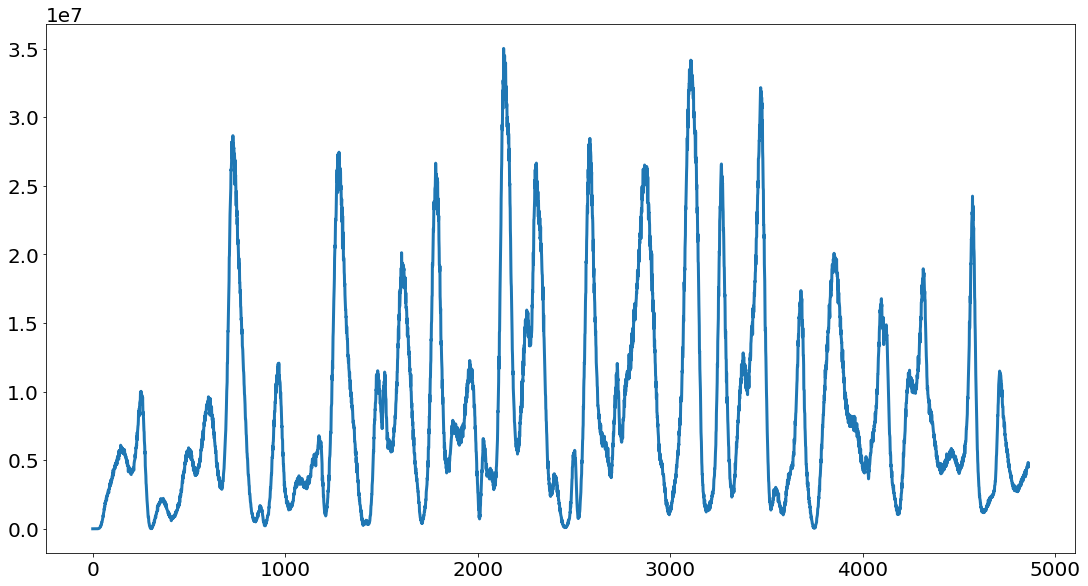

In [35]:
plt.plot(np.arange(nslice),np.abs(Efield[:,150,150])**2)

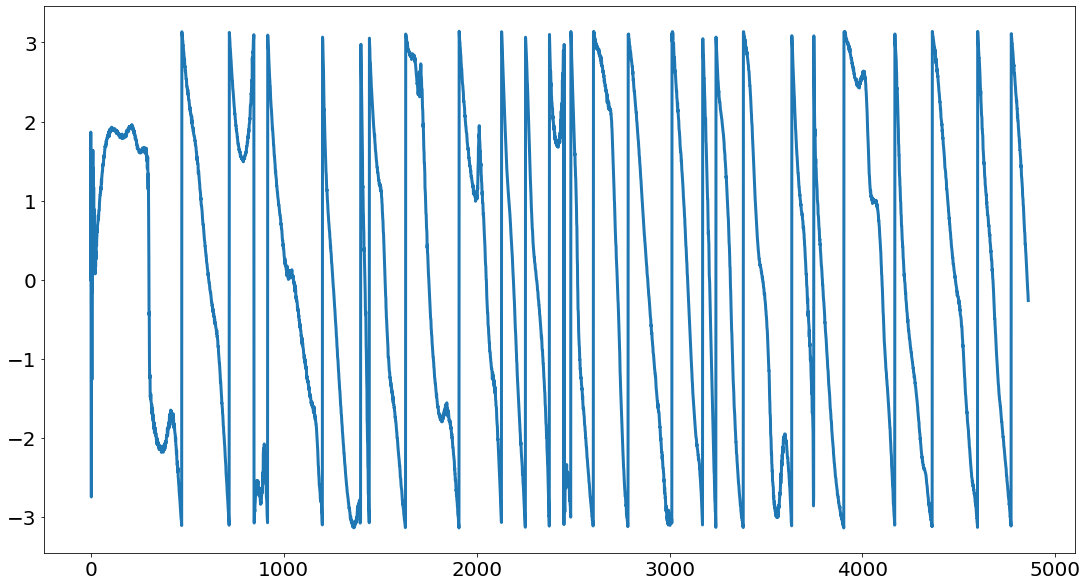

In [36]:
plt.plot(np.arange(nslice),np.angle(Efield[:,150,150]))

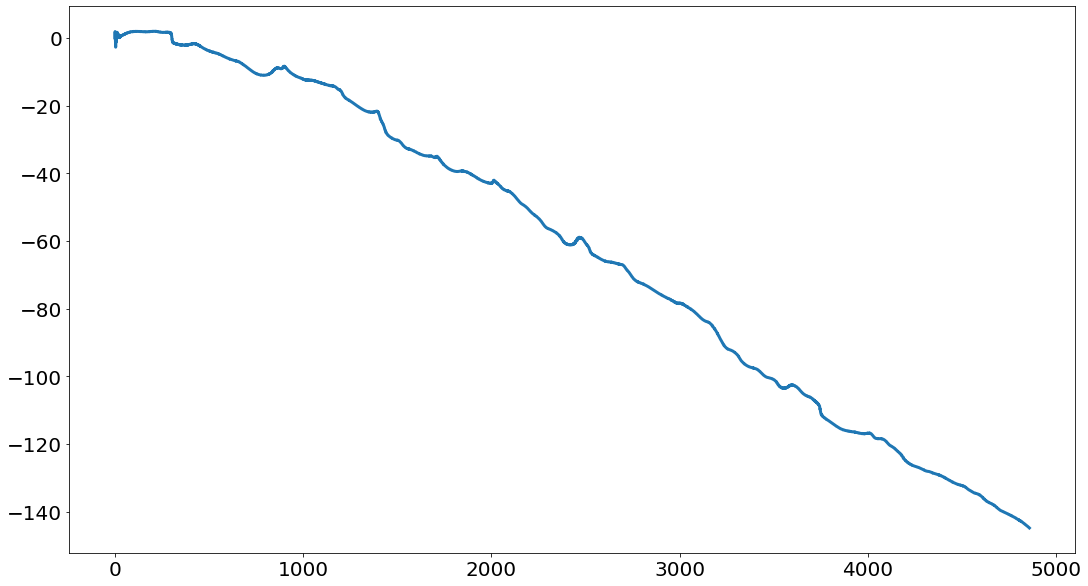

In [37]:
plt.plot(np.arange(nslice),np.unwrap(np.angle(Efield[:,150,150])))

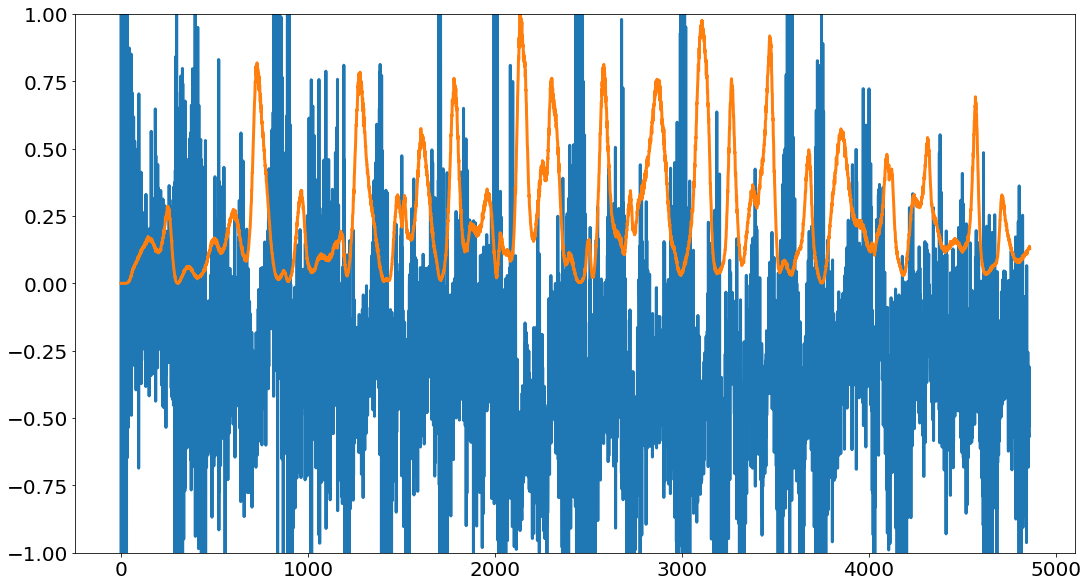

In [38]:
phi = np.unwrap(np.angle(Efield[:,150,150]))
dphi = np.diff(phi)
plt.plot(np.arange(nslice-1),dphi*10)
plt.ylim([-1,1])
I0=np.abs(Efield[:,150,150])**2
plt.plot(np.arange(nslice),I0/max(I0))

(1200.0, 1400.0)

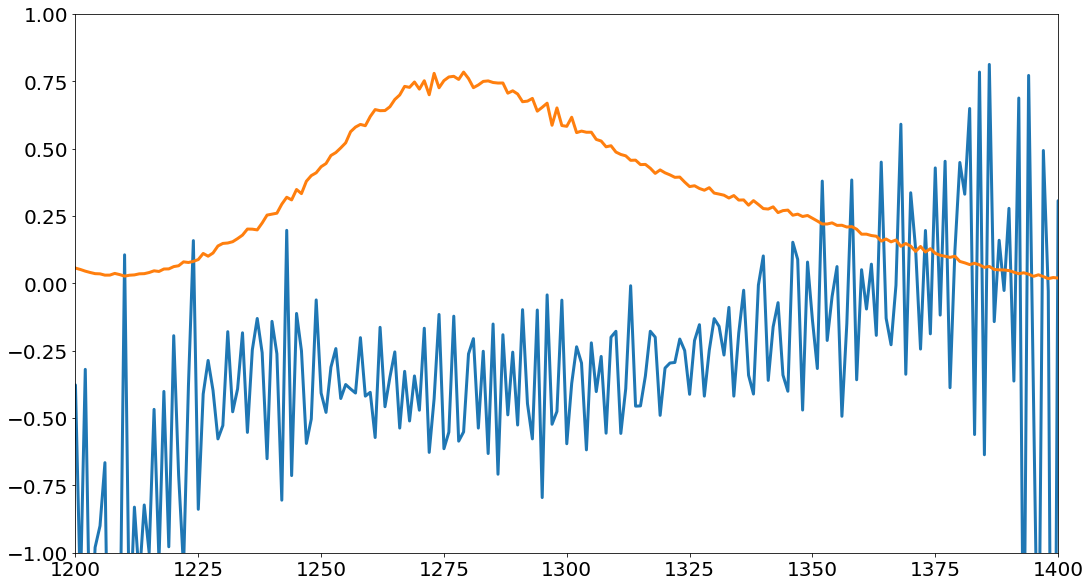

In [39]:
phi = np.unwrap(np.angle(Efield[:,150,150]))
dphi = np.diff(phi)
plt.plot(np.arange(nslice-1),dphi*10)
plt.ylim([-1,1])
I0=np.abs(Efield[:,150,150])**2
plt.plot(np.arange(nslice),I0/max(I0))
plt.xlim([1200,1400])

# Wavefront sensor

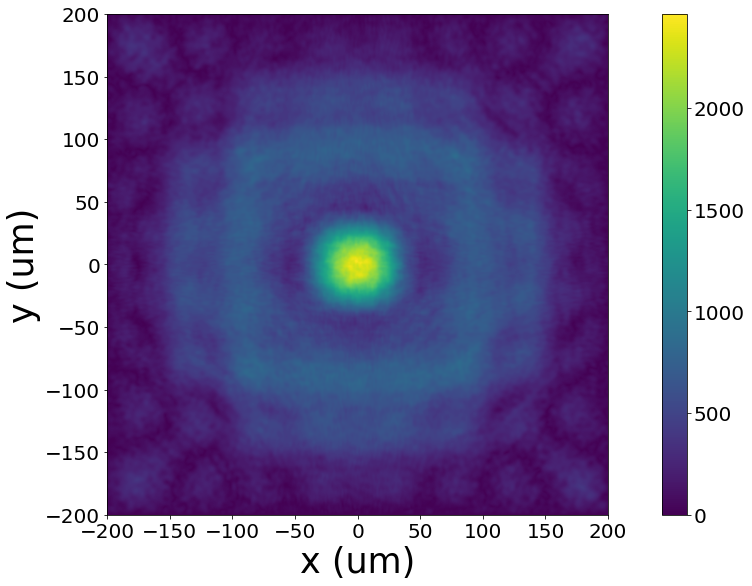

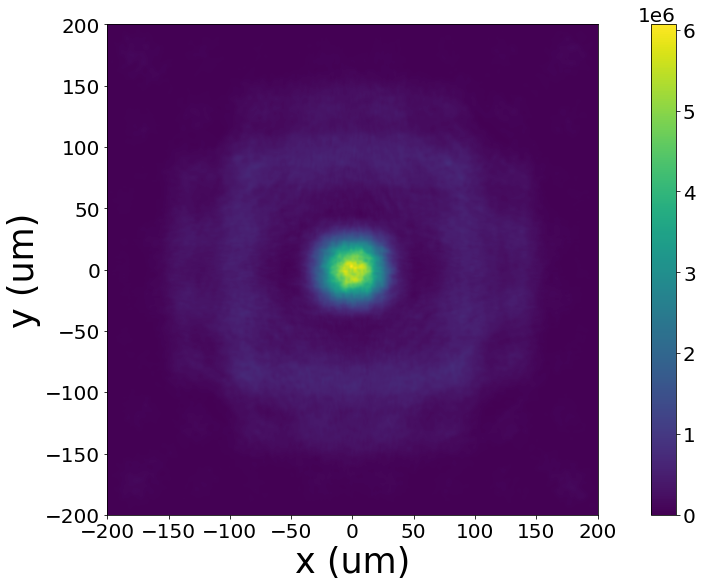

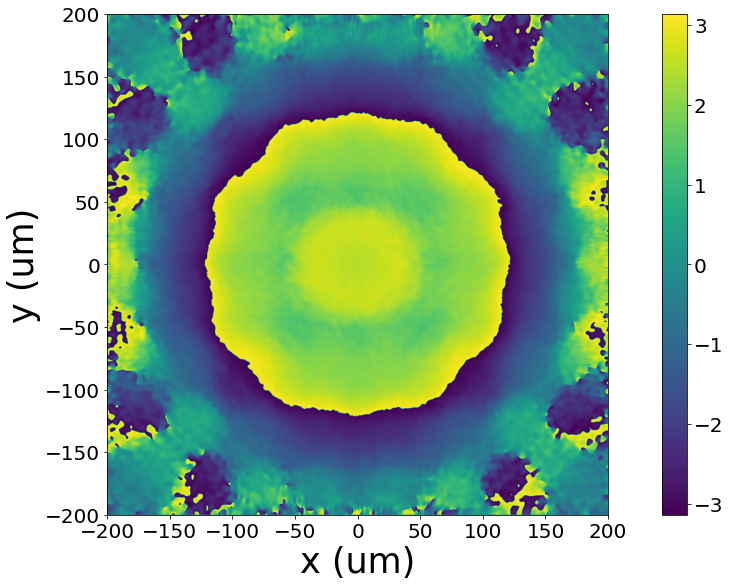

In [40]:
with h5py.File('many_spikes.643.fld.h5','r') as fldj:

    rfieldj = fldj['slice000500/field-real'][()]
    ifieldj = fldj['slice000500/field-imag'][()]
    gridsizej = fldj['gridsize'][()][0]
    gridpointsj= fldj['gridpoints'][()][0]

rfieldj = rfieldj.reshape([gridpointsj,gridpointsj])
ifieldj = ifieldj.reshape([gridpointsj,gridpointsj])

xmaxj = (gridpointsj-1)/2*gridsizej*1e6 # unit: m=>um
xminj = -xmaxj
ymaxj = xmaxj
yminj = -ymaxj

frj = RectBivariateSpline(np.linspace(xminj,xmaxj,301),np.linspace(yminj,ymaxj,301),rfieldj)
fij = RectBivariateSpline(np.linspace(xminj,xmaxj,301),np.linspace(yminj,ymaxj,301),ifieldj)

# interpolate to make pixels a factor of 6 smaller.
xij = np.linspace(xminj,xmaxj,1800)
yij = np.linspace(yminj,ymaxj,1800)
xij,yij = np.meshgrid(xij,yij)

rfieldj = frj.ev(yij,xij)
ifieldj = fij.ev(yij,xij)
    
fieldj = rfieldj+1j*ifieldj
# field=field.reshape([gridpoints,gridpoints])

# field[np.abs(field)<50] = 0


plt.figure()
plt.imshow(np.abs(fieldj),extent=(xminj,xmaxj,yminj,ymaxj))
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar()

plt.figure()
plt.imshow(np.abs(fieldj)**2,extent=(xminj,xmaxj,yminj,ymaxj))
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar()

plt.figure()
plt.imshow(np.angle(fieldj),extent=(xminj,xmaxj,yminj,ymaxj))
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar()

# plt.figure()
# plt.imshow(rfield.reshape([gridpoints,gridpoints]))

# plt.figure()
# plt.imshow(ifield.reshape([gridpoints,gridpoints]))

# Fit the $w_0$ and $I_0$ (for $E_0$)

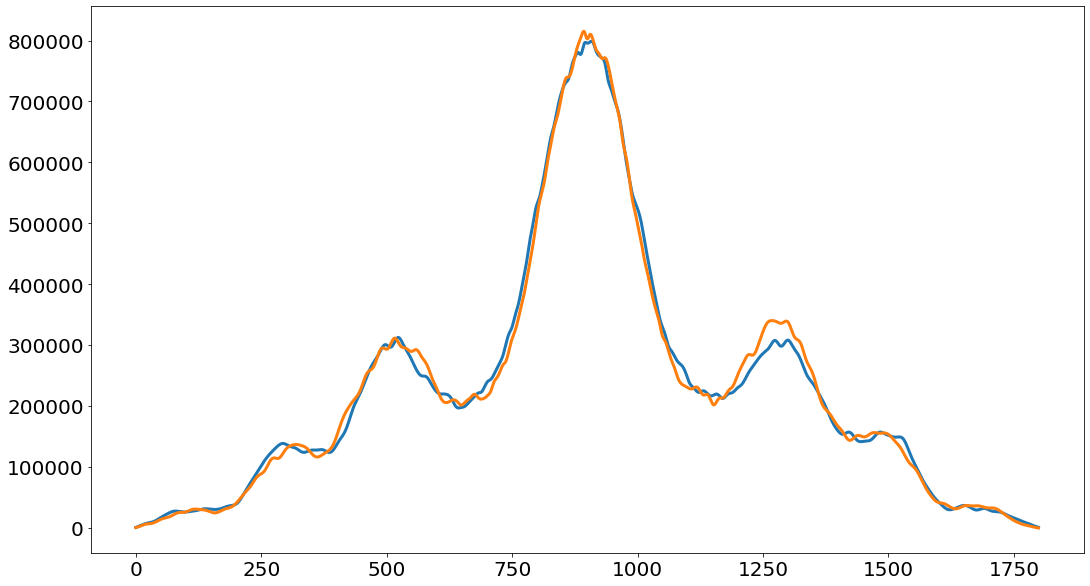

In [41]:
plt.plot(np.mean(np.abs(fieldj)**2,axis=0))
plt.plot(np.mean(np.abs(fieldj)**2,axis=1))

Fitted peak =  778346.7454035621
Fitted mean =  7.889723102199499e-09
Fitted standard deviation =  26.072323756462588
Fitted peak =  787400.3561722294
Fitted mean =  0.20329603392087545
Fitted standard deviation =  24.809814675505628
Fitted peak x data =  527324.52598352
Fitted mean x data =  7.898957169012702e-09
Fitted standard deviation x data =  66.96644683050897
Fitted peak y data =  516492.4154657093
Fitted mean y data =  2.29628527650993
Fitted standard deviation y data =  69.24937381841814
50.882138431968215
782873.5507878957


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.36-py3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


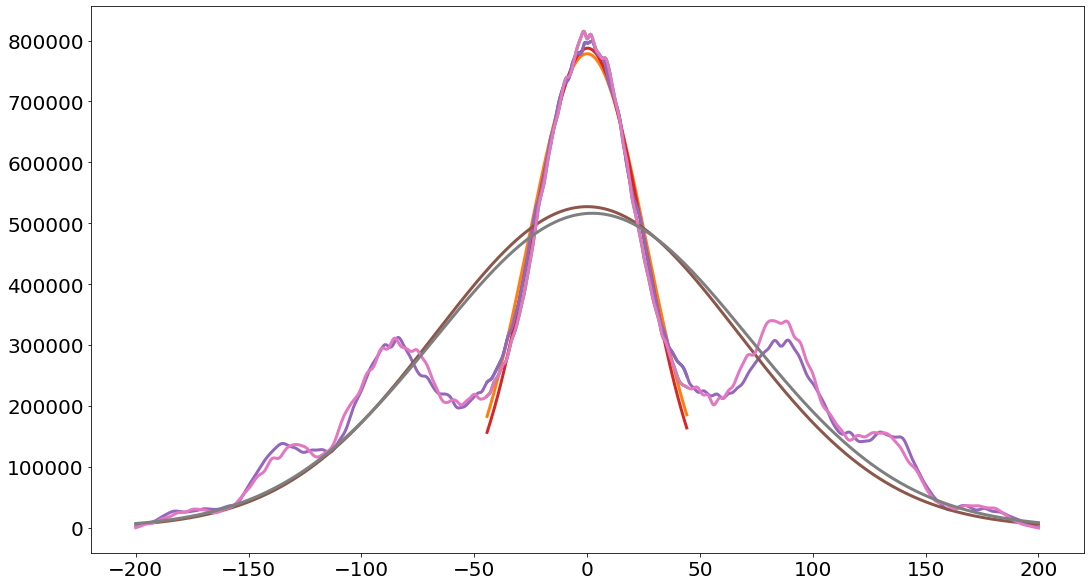

In [42]:
datax=np.mean(np.abs(fieldj)**2,axis=0)
datay=np.mean(np.abs(fieldj)**2,axis=1)

#hist, bin_edges = np.histogram(datax, density=True)
#bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
#Efieldg=np.zeros((nsliceg,ngridg,ngridg))+np.zeros((nsliceg,ngridg,ngridg))*1j

xijf = np.linspace(xminj,xmaxj,1800)
yijf = np.linspace(yminj,ymaxj,1800)
#xij,yij = np.meshgrid(xij,yij)

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [2.e+12, 0., 10.]

xfitlow = 700
xfitup = 1099
yfitlow = 700
yfitup = 1099

coeffxf, var_matrixxf = curve_fit(gauss, xijf[xfitlow:xfitup], datax[xfitlow:xfitup], p0=p0)
coeffyf, var_matrixyf = curve_fit(gauss, yijf[yfitlow:yfitup], datay[yfitlow:yfitup], p0=p0)
coeffx, var_matrixx = curve_fit(gauss, xijf, datax, p0=p0)
coeffy, var_matrixy = curve_fit(gauss, yijf, datay, p0=p0)

# Get the fitted curve
hist_fitxf = gauss(xijf[xfitlow:xfitup], *coeffxf)
hist_fityf = gauss(yijf[yfitlow:yfitup], *coeffyf)
hist_fitx = gauss(xijf, *coeffx)
hist_fity = gauss(yijf, *coeffy)

plt.plot(xijf[xfitlow:xfitup], datax[xfitlow:xfitup], label='Test data')
plt.plot(xijf[xfitlow:xfitup], hist_fitxf, label='Fitted data')
plt.plot(yijf[yfitlow:yfitup], datay[yfitlow:yfitup], label='Test data')
plt.plot(yijf[yfitlow:yfitup], hist_fityf, label='Fitted data')
plt.plot(xijf, datax, label='Test data')
plt.plot(xijf, hist_fitx, label='Fitted data')
plt.plot(yijf, datay, label='Test data')
plt.plot(yijf, hist_fity, label='Fitted data')

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted peak = ', coeffxf[0]) 
print('Fitted mean = ', coeffxf[1])
print('Fitted standard deviation = ', coeffxf[2]) 

print('Fitted peak = ', coeffyf[0]) 
print('Fitted mean = ', coeffyf[1])
print('Fitted standard deviation = ', coeffyf[2]) 

print('Fitted peak x data = ', coeffx[0]) 
print('Fitted mean x data = ', coeffx[1])
print('Fitted standard deviation x data = ', coeffx[2])

print('Fitted peak y data = ', coeffy[0]) 
print('Fitted mean y data = ', coeffy[1])
print('Fitted standard deviation y data = ', coeffy[2]) 

w0fit = 2*((coeffxf[2] + coeffyf[2])/2)
i0fit = (coeffxf[0] + coeffyf[0])/2
print(w0fit)
print(i0fit)

# Strehl index

In [43]:
def sRatio(phase,tI,bar):
    ids=tI>bar
    expcom=np.exp(phase*1j)
    if len(expcom[ids])==0:
        return np.nan
    else:
        smean=np.mean(expcom[ids])
        sR=np.abs(smean)**2
        return sR

In [44]:
#phij = np.unwrap(np.angle(Efield))[()]
phij = np.angle(Efield)[()]
#dphi = np.diff(phi)
#plt.plot(np.arange(nslice-1),dphi*10)
#plt.ylim([-1,1])
I0j=(np.abs(Efield)**2)[()]
#plt.plot(np.arange(nslice),I0/max(I0))
#aphase=fi['wavefront'][()]
#Ib=np.abs(fi['recoveredBeam'][()])**2
#I0=fi['I0'][()]

(90300,)


Text(0.5, 1.0, 'Selected Area')

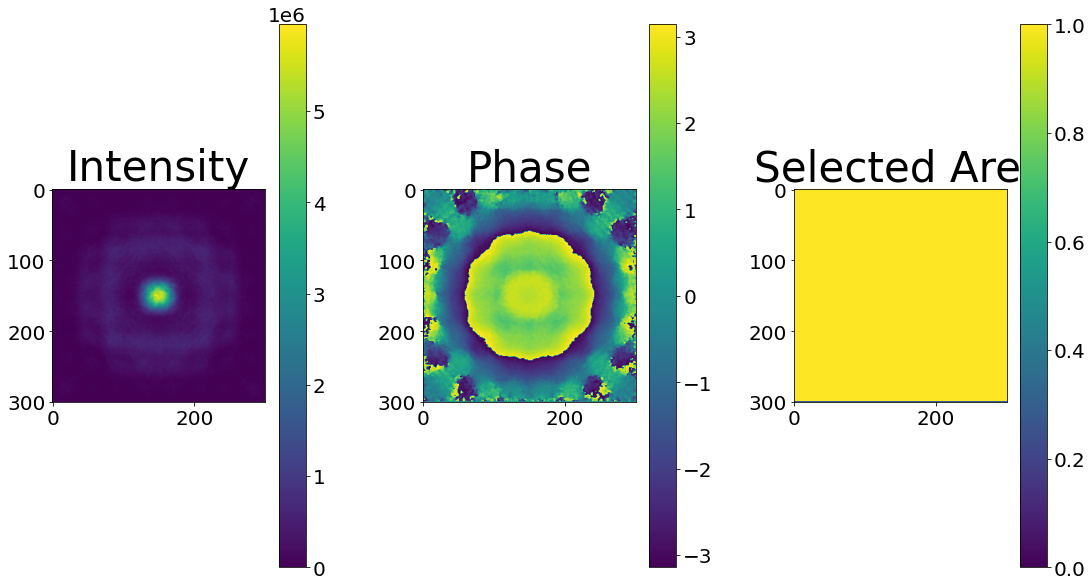

In [45]:
i=500
tIj=I0j[i,:,:]
tphasej=phij[i,:,:]
idsj=tIj>0.001
expcomj=np.exp(tphasej*1j)
smeanj=np.mean(expcomj[idsj])
print(expcomj[idsj].shape)
sRj=np.abs(smeanj)**2
plt.subplot(1,3,1)
plt.imshow(tIj)
plt.colorbar()
plt.title('Intensity')
plt.subplot(1,3,2)
#plt.imshow(unwrap_phase(tphasej))
plt.imshow(tphasej)
plt.colorbar()
plt.title('Phase')
plt.subplot(1,3,3)
plt.imshow(idsj)
plt.colorbar()
plt.title('Selected Area')

In [46]:
sratioj=np.zeros(phij.shape[0])

In [47]:
bar=80
for i in tqdm.trange(phij.shape[0]):
    tphase=phij[i,:,:]
    tI=I0j[i,:,:]
    sratioj[i]=sRatio(tphase,tI,bar)

100%|██████████| 4860/4860 [00:30<00:00, 156.98it/s]


In [48]:
Iintj=np.zeros(I0j.shape[0])

In [49]:
for i in tqdm.trange(I0j.shape[0]):
    Iintj[i]=np.sum(I0j[i,:,:])

100%|██████████| 4860/4860 [00:00<00:00, 14316.49it/s]


Text(0.5, 0, 'Slice Total Intensity ')

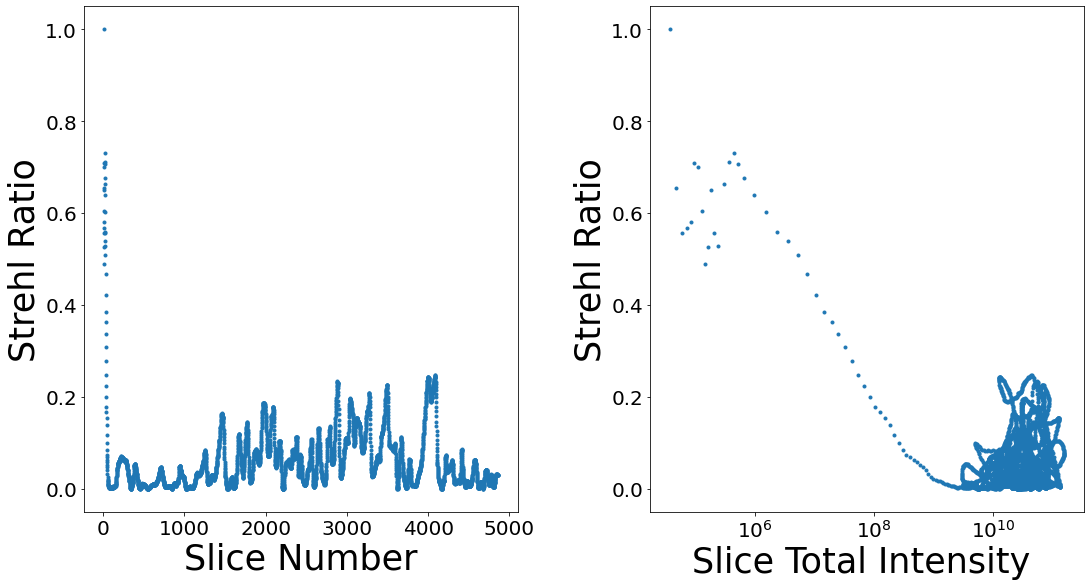

In [50]:
plt.subplot(1,2,1)
plt.plot(sratioj,'.')
plt.ylabel('Strehl Ratio')
plt.xlabel('Slice Number')
plt.subplot(1,2,2)
plt.semilogx(Iintj,sratioj,'.')
plt.ylabel('Strehl Ratio')
plt.xlabel('Slice Total Intensity ')

# Now test region of interest (100:200)

In [51]:
sratioj=np.zeros(phij.shape[0])

In [52]:
bar=80
lown = 100
upn = 200
for i in tqdm.trange(phij.shape[0]):
    tphase=phij[i,lown:upn,lown:upn]
    tI=I0j[i,lown:upn,lown:upn]
    sratioj[i]=sRatio(tphase,tI,bar)

100%|██████████| 4860/4860 [00:03<00:00, 1328.64it/s]


In [53]:
Iintj=np.zeros(I0j.shape[0])

In [54]:
for i in tqdm.trange(I0j.shape[0]):
    Iintj[i]=np.sum(I0j[i,lown:upn,lown:upn])

100%|██████████| 4860/4860 [00:00<00:00, 36666.66it/s]


Text(0.5, 0, 'Slice Total Intensity ')

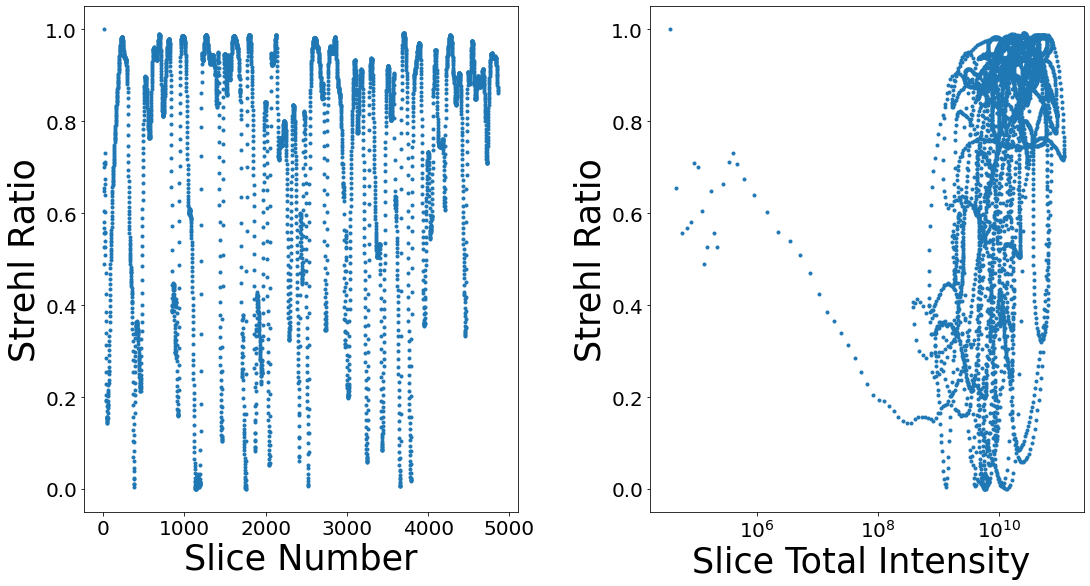

In [55]:
plt.subplot(1,2,1)
plt.plot(sratioj,'.')
plt.ylabel('Strehl Ratio')
plt.xlabel('Slice Number')
plt.subplot(1,2,2)
plt.semilogx(Iintj,sratioj,'.')
plt.ylabel('Strehl Ratio')
plt.xlabel('Slice Total Intensity ')

# Now test narrower region of interest (130:170)

In [56]:
sratioj=np.zeros(phij.shape[0])

In [57]:
bar=80
lown = 130
upn = 170
for i in tqdm.trange(phij.shape[0]):
    tphase=phij[i,lown:upn,lown:upn]
    tI=I0j[i,lown:upn,lown:upn]
    sratioj[i]=sRatio(tphase,tI,bar)

100%|██████████| 4860/4860 [00:00<00:00, 6824.78it/s]


In [58]:
Iintj=np.zeros(I0j.shape[0])

In [59]:
for i in tqdm.trange(I0j.shape[0]):
    Iintj[i]=np.sum(I0j[i,lown:upn,lown:upn])

100%|██████████| 4860/4860 [00:00<00:00, 80158.54it/s]


Text(0.5, 0, 'Slice Total Intensity ')

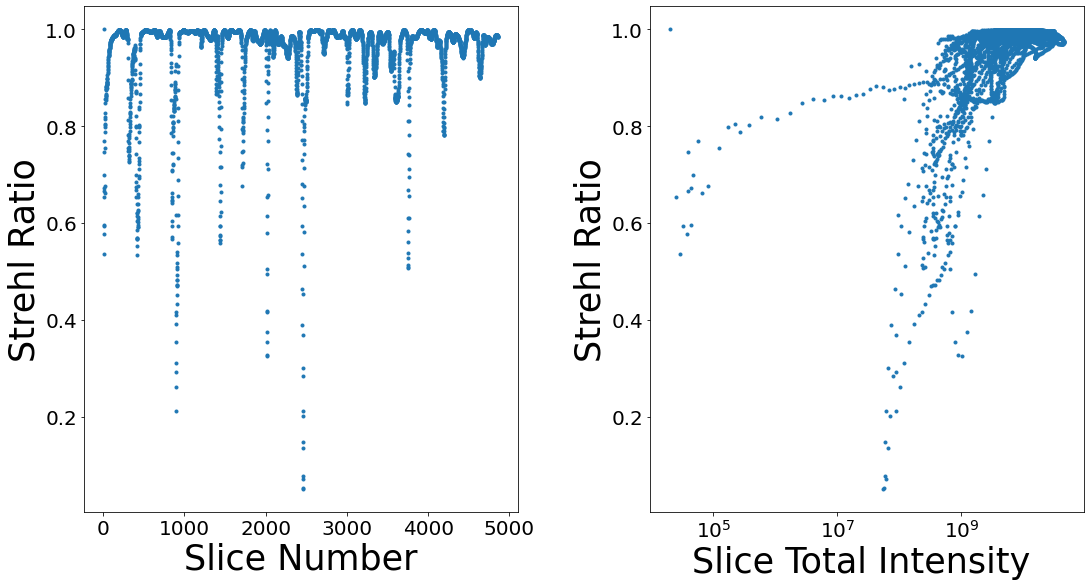

In [60]:
plt.subplot(1,2,1)
plt.plot(sratioj,'.')
plt.ylabel('Strehl Ratio')
plt.xlabel('Slice Number')
plt.subplot(1,2,2)
plt.semilogx(Iintj,sratioj,'.')
plt.ylabel('Strehl Ratio')
plt.xlabel('Slice Total Intensity ')

# Work on a Gaussian Beam

## Define a Gaussian Beam

In [61]:
def GaussianBeam(fname,zslice,xgrid,ygrid):
    #print(zslice,xgrid,ygrid)
    with h5py.File(fname,'r') as outGau:
        print(fname)
        xlamds = outGau['Global/lambdaref'][()]
        ks = 2*np.pi/xlamds
        zRayleigh = np.pi*w0fit**2/xlamds
        zsep= outGau['Global/sample'][()]
        deltaz = xlamds*zsep
        wzslice = w0fit*np.sqrt(1+((zslice - np.floor(nslice/2))*deltaz)**2/zRayleigh**2)
        #if zslice - np.floor(nslice/2) == 0:
        #    rCapzslice = (1.0e-07)*deltaz*(1 + (zRayleigh/(1.0e-07)/deltaz)**2)
        #else:
        #    rCapzslice = (zslice - np.floor(nslice/2))*deltaz*(1 
        #                    + (zRayleigh/(zslice - np.floor(nslice/2))/deltaz)**2)   
        rCapzslice = (zslice*(1+(1.0e-07)) - np.floor(nslice/2))*deltaz*(1 
                            + (zRayleigh/(zslice*(1+(1.0e-07)) - np.floor(nslice/2))/deltaz)**2) 
        psizslice = 1/np.tan((zslice - np.floor(nslice/2))*deltaz/zRayleigh)
        #psizslice = math.atan((zslice*(1+(1.0e-07)) - np.floor(nslice/2))*deltaz/zRayleigh)
        deltax = gridsizej
        deltay = gridsizej
        rsquare = (((xgrid - np.floor(gridpointsj/2))*deltax)**2 + 
                   ((ygrid - np.floor(gridpointsj/2))*deltay)**2)
        phasezslice = ks*zslice*deltaz + ks*rsquare/2/rCapzslice - psizslice
    #    elecfield = np.sqrt(i0fit)*w0fit/wzslice*np.exp(-rsquare/wzslice**2)*np.exp(-1j*phasezslice)
    #    rfieldGau = elecfield.real
    #    ifieldGau = elecfield.imag
    #return rfieldGau, ifieldGau
    return np.sqrt(i0fit)*w0fit/wzslice*np.exp(-rsquare/wzslice**2)*np.exp(-1j*phasezslice)

In [64]:
#EfieldGau=np.zeros((nslice,ngrid,ngrid))+np.zeros((nslice,ngrid,ngrid))*1j

In [48]:
#def func2(x, y, z):
#    #print(np.sin(y * x)+z)
#    return np.sin(y * x)+z
#
#xaxis = np.linspace(0, 4, 10)
#yaxis = np.linspace(-1, 1, 20)
#zaxis = np.linspace(0, 1, 20)
#result2 = func2(xaxis[:,None,None], yaxis[None,:,None],zaxis[None,None,:])
#result3 = GaussianBeam(f2r,xaxis[:,None,None], yaxis[None,:,None],zaxis[None,None,:])

In [65]:
#def fGau3(numk,numi,numj):
#    #k = np.arange(numk)
#    #i = np.arange(numi)#, dtype=np.float)
#    #j = np.arange(numj)#, dtype=np.float)
#    realt, imagt = GaussianBeam(f2r,numk,numi,numj)
#    #fieldt = realt + 1j*imagt
#    EfieldGau[numk,numi,numj] = realt + 1j*imagt
#    return EfieldGau[numk,numi,numj]
##def func2(x, y, z):
##    return np.sin(y * x)+z

#xaxis = range(ngrid)#np.linspace(0, ngrid - 1, 1)
#yaxis = range(ngrid)#np.linspace(0, ngrid - 1, 1)
#zaxis = range(nslice)#np.linspace(0, nslice - 1, 1)

## Create a Gaussian Beam

In [62]:
xaxis = np.linspace(0,ngrid-1,ngrid)
yaxis = np.linspace(0,ngrid-1,ngrid)
zaxis = np.linspace(0,nslice-1,nslice)

In [63]:
#nx, ny, nz = (3, 2, 5)
#xaxis = np.linspace(0, 1, nx)
#yaxis = np.linspace(0, 1, ny)
#zaxis = np.linspace(0, 1, nz)
z, x, y = np.meshgrid(zaxis, xaxis, yaxis)
EfieldGau = GaussianBeam(f2r,z,x,y)

../../../../2021/09Sep/09302021/slice_ana/LCLS2_SXR.out.h5


/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.36-py3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in true_divide
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.36-py3/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in multiply
/cds/sw/ds/ana/conda1/inst/envs/ana-4.0.36-py3/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in exp


In [97]:
#realt = result.real
#imagt = result.imag
#GaussianBeam(f2r,numk,numi,numj)
#result3 = fGau3(zaxis, xaxis,yaxis)
#fGau3(xaxis[:,None,None], yaxis[None,:,None],zaxis[None,None,:])

In [65]:
Efield.shape

(4860, 301, 301)

In [66]:
EfieldGau.shape

(301, 4860, 301)

In [81]:
#for i in tqdm.trange(ngrid):
#    for j in range(ngrid):
#        realt, imagt = GaussianBeam(f2r,0,i,j)
#        fieldt = realt + 1j*imagt
#        EfieldGau[0,i,j]=fieldt

100%|██████████| 301/301 [02:53<00:00,  1.73it/s]


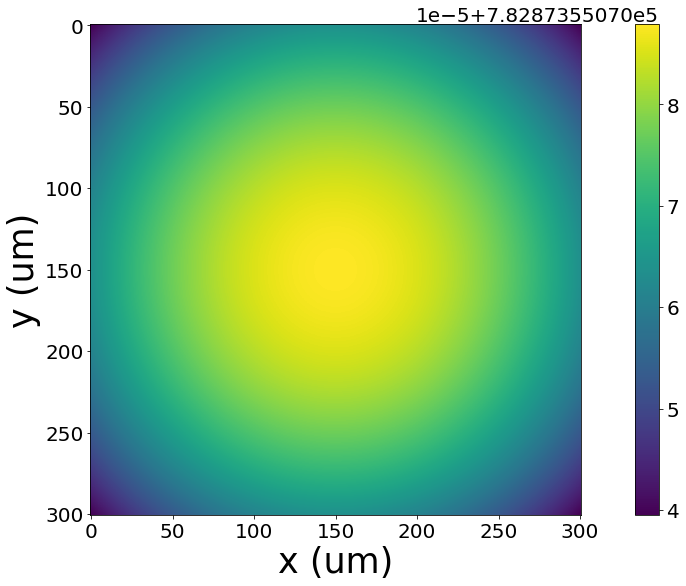

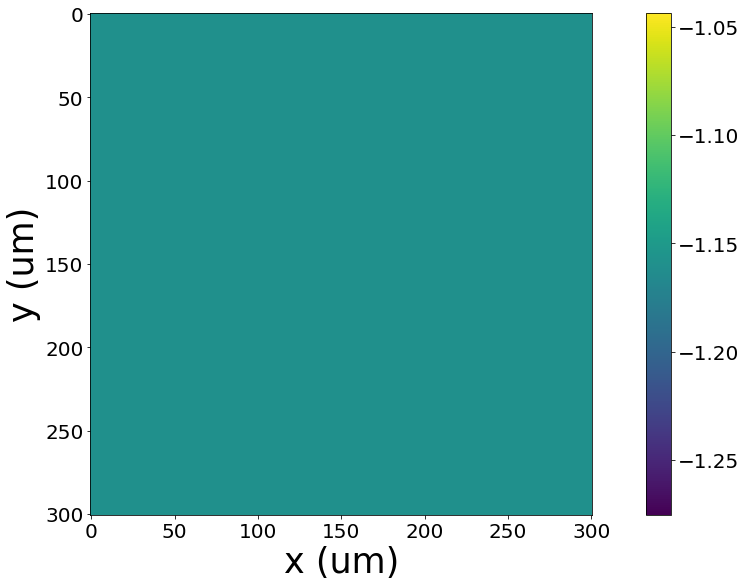

In [73]:
pltSlice = 4000

plt.figure()
plt.imshow(np.abs(EfieldGau[:,pltSlice,:])**2)#,extent=(xminj,xmaxj,yminj,ymaxj))
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar()

plt.figure()
plt.imshow(np.angle(EfieldGau[:,pltSlice,:]))#,extent=(xminj,xmaxj,yminj,ymaxj))
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar()

# Duplicate a fld.h5 file to store Gaussian pulse

In [ ]:
# shutil.copy2('./many_spikes.643.fld.h5', './many_spikes.643.fld_cp.h5')

In [4]:
#with h5py.File('./many_spikes.643.fld_cp.h5','r') as fldg:
fldg=h5py.File('./many_spikes.643.fld_cp.h5','r')

In [5]:
nsliceg=fldg['slicecount'][()][0]
ngridg=fldg['gridpoints'][()][0]
print(nsliceg)
print(ngridg)

4860
301


In [6]:
fldg['slice000001'+'/field-real'].shape
fldg['slice000001'+'/field-imag'].shape

(90601,)

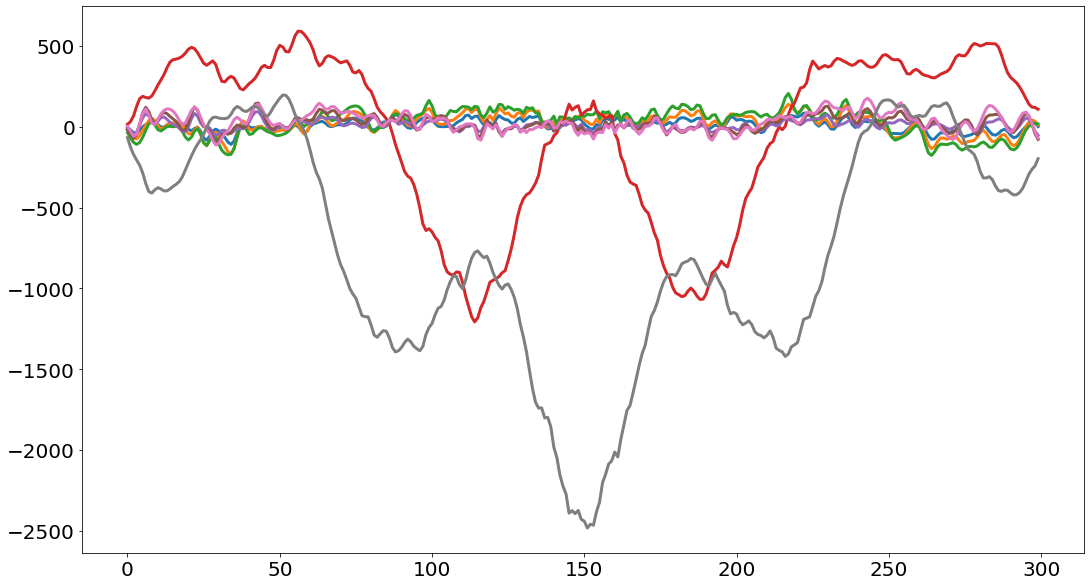

In [13]:
plt.plot(fldg['slice002101'+'/field-real'][0:300])
plt.plot(fldg['slice002101'+'/field-real'][301:601])
plt.plot(fldg['slice002101'+'/field-real'][602:902])
plt.plot(fldg['slice002101'+'/field-real'][150*301:151*301-1])
plt.plot(fldg['slice002101'+'/field-imag'][0:300])
plt.plot(fldg['slice002101'+'/field-imag'][301:601])
plt.plot(fldg['slice002101'+'/field-imag'][602:902])
plt.plot(fldg['slice002101'+'/field-imag'][150*301:151*301-1])

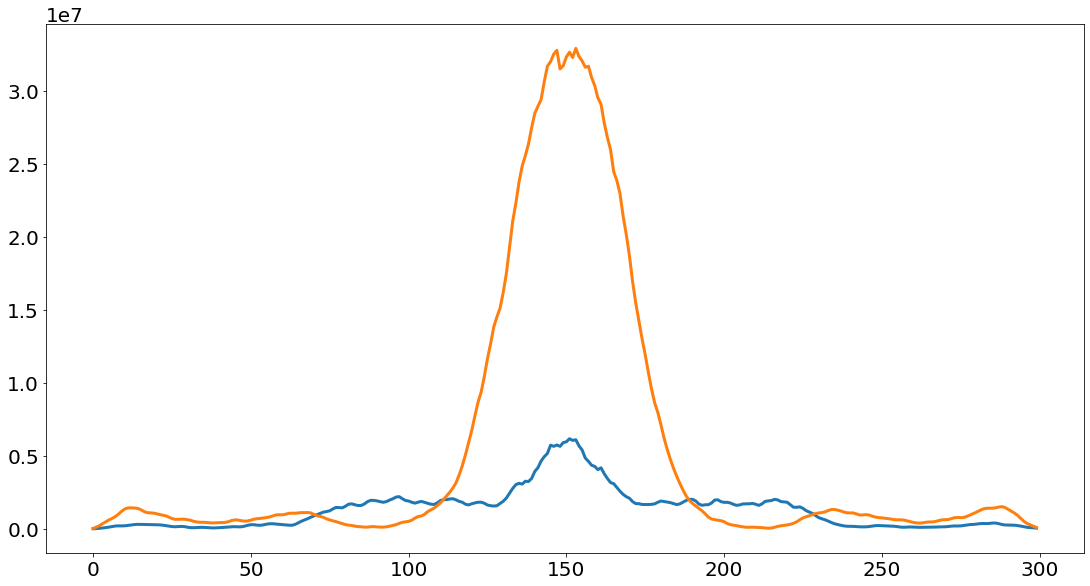

In [15]:
plt.plot((fldg['slice002101'+'/field-real'][150*301:151*301-1])**2 + (fldg['slice002101'+'/field-imag'][150*301:151*301-1])**2)
plt.plot((fldg['slice003101'+'/field-real'][150*301:151*301-1])**2 + (fldg['slice003101'+'/field-imag'][150*301:151*301-1])**2)

In [26]:
Efieldg=np.zeros((nsliceg,ngridg,ngridg))+np.zeros((nsliceg,ngridg,ngridg))*1j

In [27]:
for i in tqdm.trange(1,nsliceg+1):
    isliceg='slice'+str(i).zfill(6)
    rfieldg = fldg[isliceg+'/field-real'][()]
    ifieldg = fldg[isliceg+'/field-imag'][()]
    rfieldg = rfieldg.reshape([ngridg,ngridg])
    ifieldg = ifieldg.reshape([ngridg,ngridg])
    fieldg = rfieldg+1j*ifieldg
    Efieldg[i-1,:,:]=fieldg

100%|██████████| 4860/4860 [00:11<00:00, 437.95it/s]


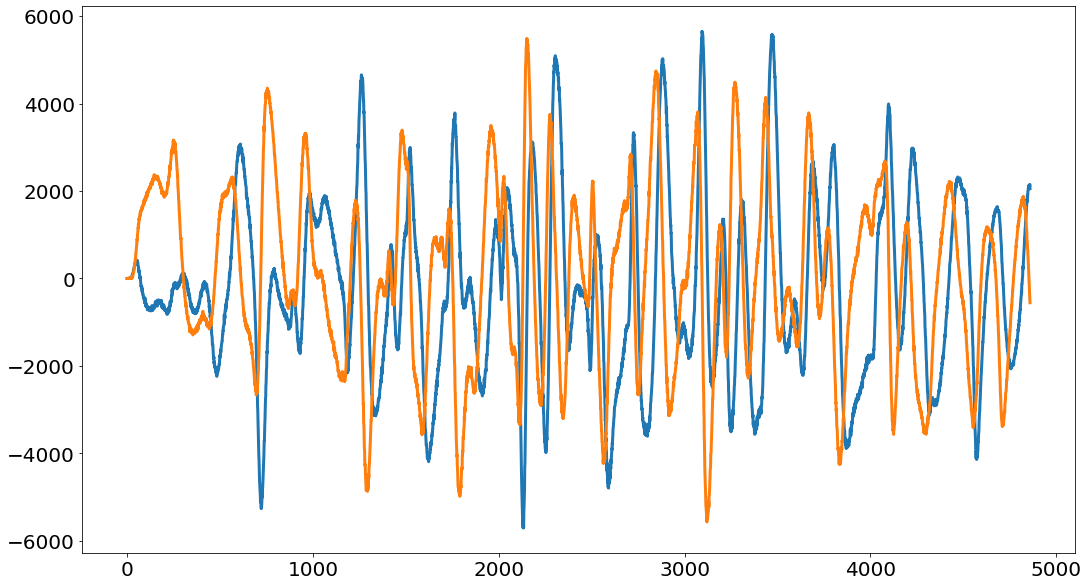

In [28]:
plt.plot(np.arange(nsliceg),Efieldg[:,150,150].real)
plt.plot(np.arange(nsliceg),Efieldg[:,150,150].imag)

## Write to the h5 file

In [83]:
#testGau2 = EfieldGau[:,0,:]
testGau1 = EfieldGau[:,0,:].reshape([ngrid*ngrid])

In [84]:
testGau1.shape

(90601,)

In [86]:
# for simple purpose, can duplicate a .fld.h5 into Gaussian.fld.h5, and replace the field
os.system('cp many_spikes.643.fld_cp.h5 many_spikes.Gaussian.fld.h5')
hfGau = h5py.File('many_spikes.Gaussian.fld.h5', 'w')

for i in tqdm.trange(1,nslice+1):
    isliceg='slice'+str(i).zfill(6)
    #rfieldg = fldg[isliceg+'/field-real'][()]
    #ifieldg = fldg[isliceg+'/field-imag'][()]
    #rfieldg = rfieldg.reshape([ngridg,ngridg])
    #ifieldg = ifieldg.reshape([ngridg,ngridg])
    #fieldg = rfieldg+1j*ifieldg
    #Efieldg[i-1,:,:]=fieldg
    testGau1 = EfieldGau[:,i-1,:].reshape([ngrid*ngrid])
    hfGau.create_dataset(isliceg+'/field-real', data=testGau1.real)
    hfGau.create_dataset(isliceg+'/field-imag', data=testGau1.imag)
    
hfGau.close()

100%|██████████| 4860/4860 [00:15<00:00, 316.60it/s]


In [ ]:
#rfieldGau, ifieldGau = GaussianBeam(xgrid,ygrid,zslice)

# for simple purpose, can duplicate a .fld.h5 into Gaussian.fld.h5, and replace the field
#os.system('cp many_spikes.643.fld.h5 many_spikes.Gaussian.fld.h5')
#hfGau = h5py.File('LCLS2_SXR.Gaussian.fld.h5', 'w')

#rfd = fld['slice000500'+'/field-real'][()]  #This section is purely a test to understand the data type and reshpae 
#type(rfd)
#rfd2 = rfd.reshape([ngrid, ngrid])
#type(rfd2)
#len(rfd2)
#rfd2

#hfGau.create_dataset('slice000500'+'/field-real', data=rfieldGau)
#hfGau.create_dataset('slice000500'+'/field-imag', data=ifieldGau)

## Test the replaced Gaussian pulse

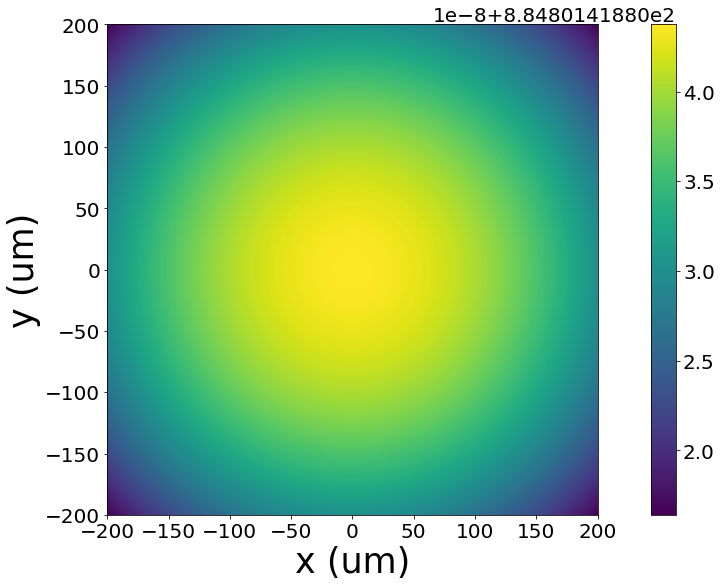

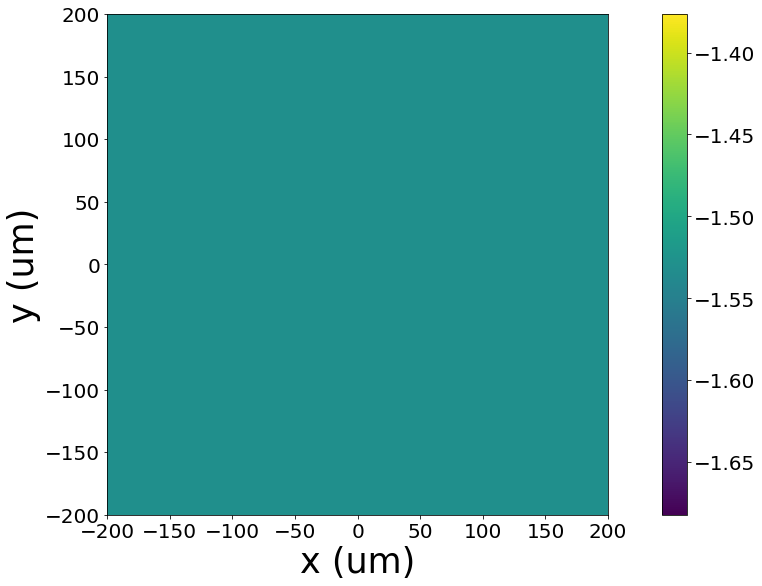

In [91]:
with h5py.File('./many_spikes.Gaussian.fld.h5','r') as fldg:

    rfieldg = fldg['slice000500/field-real'][()]
    ifieldg = fldg['slice000500/field-imag'][()]
    gridsizeg = gridsizej #fldg['gridsize'][()][0]
    gridpointsg= gridpointsj #fldg['gridpoints'][()][0]

rfieldg = rfieldg.reshape([gridpointsg,gridpointsg])
ifieldg = ifieldg.reshape([gridpointsg,gridpointsg])

xmaxg = (gridpointsg-1)/2*gridsizeg*1e6 # unit: m=>um
xming = -xmaxg
ymaxg = xmaxg
yming = -ymaxg

frg = RectBivariateSpline(np.linspace(xming,xmaxg,301),np.linspace(yming,ymaxg,301),rfieldg)
fig = RectBivariateSpline(np.linspace(xming,xmaxg,301),np.linspace(yming,ymaxg,301),ifieldg)

# interpolate to make pixels a factor of 6 smaller.
xig = np.linspace(xming,xmaxg,1800)
yig = np.linspace(yming,ymaxg,1800)
xig,yig = np.meshgrid(xig,yig)

rfieldg = frg.ev(yig,xig)
ifieldg = fig.ev(yig,xig)
    
fieldg = rfieldg+1j*ifieldg
# field=field.reshape([gridpoints,gridpoints])

# field[np.abs(field)<50] = 0


plt.figure()
plt.imshow(np.abs(fieldg),extent=(xming,xmaxg,yming,ymaxg))
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar()

plt.figure()
plt.imshow(np.angle(fieldg),extent=(xming,xmaxg,yming,ymaxg))
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar()

# plt.figure()
# plt.imshow(rfield.reshape([gridpoints,gridpoints]))

# plt.figure()
# plt.imshow(ifield.reshape([gridpoints,gridpoints]))

# Generate a Single Spike

In [75]:
efield=Efield[1200:1400,:,:]

In [75]:
f = h5py.File('single_spike.h5', 'w')
f.create_dataset('efield', data=efield)
f.close()

In [75]:
f=h5py.File('single_spike.h5', 'r')
print(f.keys())

# Copy a Single Spike

In [28]:
#os.remove('./single_spike_cp.h5')

In [34]:
shutil.copy2('./single_spike.h5', './single_spike_cp.h5')

'./single_spike_cp.h5'

In [35]:
ftest=h5py.File('single_spike_cp.h5','r')
print(ftest.keys())

<KeysViewHDF5 ['efield']>


In [36]:
ftest['efield'][()].shape

(200, 301, 301)